Names:

In [2]:
# your import statements
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd

/Users/rachelwhite/Nextcloud/Teaching/EOSC511_ATSC409/ATSC409_EOSC511/numeric_2024/worksheets/Worksheets_Lab5
******************************
context imported. Front of path:
/Users/rachelwhite/Nextcloud/Teaching/EOSC511_ATSC409/ATSC409_EOSC511/numeric_2024
back of path: /Users/rachelwhite/Applications/miniforge3/envs/numeric_2024/lib/python3.12/site-packages
******************************

through /Users/rachelwhite/Nextcloud/Teaching/EOSC511_ATSC409/ATSC409_EOSC511/numeric_2024/worksheets/Worksheets_Lab5/context.py


# WorkSheet Instructions ##

Before you begin you should have read and worked through Lab 5.

 I recommend that you do this worksheet in a python
  notebook and share screen.  This method does mean one person will do the typing.  When complete, print or Latex to pdf and upload to CANVAS.

This question is based on the adaptive timestep in Runge-Kutta section on Lab 5. The Runge-Kutta algorithm with adaptive time steps will, in general, be more efficient and accurate than the same algorithm with fixed time steps. In other words, greater accuracy can usually be achieved in fewer time steps.

  

For the given set of Daisyworld parameters and initial conditions in adapt_worksheet.yaml:

## Question A ###
The code below uses the adaptive timestep Runge-Kutta for default values given in adapt_worksheet.yaml. Run this code and then decrease the error tolerances for the adaptive Runge Kutta and compare the plots. Compare your adaptive timestep solutions to the solutions for the algorithm with fixed timesteps. What do you see as the error tolerances are decreased?  You should see that as the error tolerances are decreased, the plots approach the one created by the algorithm with fixed time steps. What does this imply?


In [3]:
# functions for worksheet problems

class Integ54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi)
        f[1] = y[1] * (beta_b * bare - user.chi)
        return f

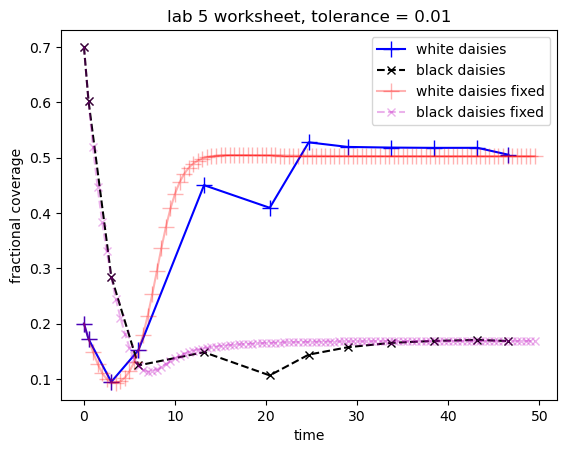

In [4]:
# Solve and plot for adaptive timestep
theSolver = Integ54('adapt_worksheet.yaml')
timeVals, yVals, errorList = theSolver.timeloop5Err()

with open('adapt_worksheet.yaml', 'rb') as f:
    config = yaml.safe_load(f)
    adaptvars_in = namedtuple('adaptvars', config['adaptvars'].keys())
    adaptvars = adaptvars_in(**config['adaptvars'])
    
yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '--kx', label='black daisies')
theAx.set_title('lab 5 worksheet, tolerance = ' + str(adaptvars.rtol))
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')

timeVals,yVals,errorList=theSolver.timeloop5fixed()
yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black'])

points, = theAx.plot(timeVals, yvals['white'], '-r+', label='white daisies fixed',alpha=0.3)
points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '--mx', label='black daisies fixed',alpha=0.3)
out = theAx.legend(loc='best')


## Question B ###  
Compare the evoluation of Daisyworld over time to a plot of the stepsizes over time in the adaptive timestep simulation. Do you see a correlation between stepsize and the shape of the curve?


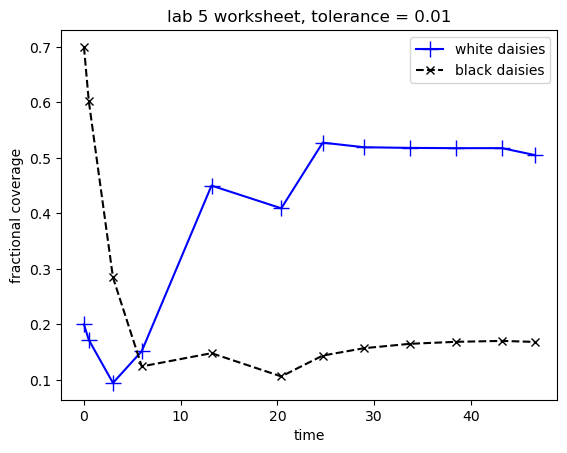

In [5]:
# Solve and plot for adaptive timestep
theSolver = Integ54('adapt_worksheet.yaml')
timeVals, yVals, errorList = theSolver.timeloop5Err()

with open('adapt_worksheet.yaml', 'rb') as f:
    config = yaml.safe_load(f)
    adaptvars_in = namedtuple('adaptvars', config['adaptvars'].keys())
    adaptvars = adaptvars_in(**config['adaptvars'])
    
yvals = pd.DataFrame.from_records(yVals, columns=['white', 'black'])

thefig, theAx = plt.subplots(1, 1)

points, = theAx.plot(timeVals, yvals['white'], '-b+', label='white daisies')
points.set_markersize(12)
theLine1, = theAx.plot(timeVals, yvals['black'], '--kx', label='black daisies')
theAx.set_title('lab 5 worksheet, tolerance = ' + str(adaptvars.rtol))
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='best')
plt.show()

# Plot stepsize
# Add your code here to plot the stepsize as a function of time

## Question C ###  
Change the tolerances and decide as a group where you would set the tolerance to get (roughly) the same plot as the fixed timestep solution, but in the fewest possible time steps. For this simulation, calculate the difference in the number of timesteps between the fixed and adaptive solutions. Work out (by "hand") roughly how much computational time the adaptive timestep algorithm has saved with your chosen tolerance if the algorithm uses a. step doubling, and b. an embedded Runge-Kutta. What is the optimal tolerance value for both accuracy and time efficiency?